## 1. 프로젝트 개요

본 프로젝트는 운전자의 피로도를 판단하기 위한 눈 감음(open/closed) 상태 분류 모델을 구축하는 것을 목적으로 한다.  
총 5명의 팀원이 각기 다른 방식(OpenCV, 머신러닝, 딥러닝 등)으로 접근하며, 본 작업자는 머신러닝 기반 접근을 담당하였다.  
모델은 Kaggle에서 수집한 Open/Closed Eyes Dataset을 활용하고, 향후 웹캠 실시간 입력에도 적용 가능하도록 설계하였다.

In [6]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import mediapipe as mp


## 2. 데이터 로딩 및 전처리

Kaggle에서 제공된 눈 이미지 데이터셋은 open과 closed 두 개의 폴더로 구성되어 있으며,  
각 이미지는 90×90 크기로 리사이즈한 후 흑백으로 변환하고 평탄화하여 1차원 배열로 저장하였다.


In [7]:
def load_images_from_folder(base_path):
    data = []
    labels = []
    for label, category in enumerate(['closed', 'open']):  # closed: 0, open: 1
        folder_path = os.path.join(base_path, category)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (90, 90))  # 이미지 크기 맞추기
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백 변환
                data.append(gray.flatten())  # 머신러닝을 위해 1차원 배열로
                labels.append(label)
    return np.array(data), np.array(labels)


In [8]:
base_path = './open-closed-eyes-dataset/train'


In [9]:

# closed, open 폴더 안의 첫 이미지 경로 테스트
for label in ['closed', 'open']:
    folder = os.path.join(base_path, label)
    print(f"[{label}] 폴더 존재 여부:", os.path.exists(folder))
    print(f"[{label}] 파일 개수:", len(os.listdir(folder)))


[closed] 폴더 존재 여부: True
[closed] 파일 개수: 33322
[open] 폴더 존재 여부: True
[open] 파일 개수: 106482


## 3. 학습용 무작위 샘플 추출 및 모델 훈련

전체 데이터를 사용하면 학습 시간이 지나치게 오래 걸리므로, 우선 open/closed 각각 500장의 이미지를 랜덤하게 선택하여 실험하였다.

In [10]:
import random
from PIL import Image

def load_images_sample_random(base_path, max_per_class=500):
    data = []
    labels = []
    for label, category in enumerate(['closed', 'open']):
        folder_path = os.path.join(base_path, category)
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(files)  # 🔁 무작위로 섞기
        for filename in files[:max_per_class]:  # 상위 N개만 사용
            img_path = os.path.join(folder_path, filename)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('L')
                    img = img.resize((90, 90))
                    data.append(np.array(img).flatten())
                    labels.append(label)
            except Exception as e:
                print("에러:", filename, e)
    return np.array(data), np.array(labels, dtype=np.int32)


In [11]:
X, y = load_images_sample_random(base_path, max_per_class=500)

print("전체 데이터 개수:", len(X))
print("레이블 분포 (0: closed, 1: open):", np.bincount(y))


전체 데이터 개수: 1000
레이블 분포 (0: closed, 1: open): [500 500]


## 4. 훈련 및 검증 데이터 분할

전체 데이터 중 20%를 검증용으로 분할하여 SVM 모델을 학습하였다.


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("학습 데이터 개수:", len(X_train))
print("검증 데이터 개수:", len(X_val))


학습 데이터 개수: 800
검증 데이터 개수: 200


In [13]:
from sklearn.svm import SVC

model = SVC(kernel='linear')  # 또는 'rbf', 'poly'도 가능
model.fit(X_train, y_train)


SVC(kernel='linear')

## 5. 모델 성능 평가 및 시각화

훈련된 SVM 모델에 대해 분류 리포트와 혼동 행렬을 출력하고, 이를 시각화하여 모델의 성능을 확인하였다.


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val)

print("분류 리포트:")
print(classification_report(y_val, y_pred, target_names=['closed', 'open']))

print("혼동행렬:")
print(confusion_matrix(y_val, y_pred))


분류 리포트:
              precision    recall  f1-score   support

      closed       0.82      0.85      0.83       100
        open       0.84      0.81      0.83       100

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200

혼동행렬:
[[85 15]
 [19 81]]


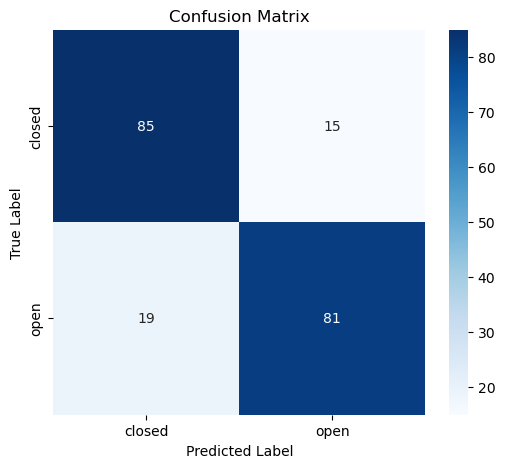

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 예측 결과
y_pred = model.predict(X_val)

# 혼동행렬 계산
cm = confusion_matrix(y_val, y_pred)
labels = ['closed', 'open']

# 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

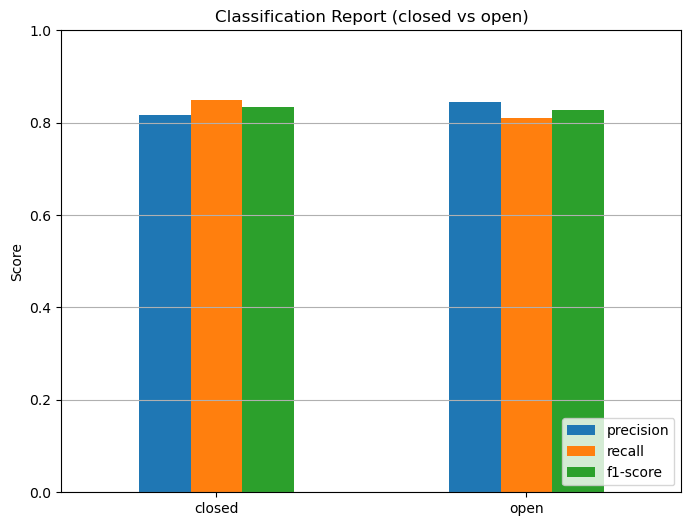

In [16]:
from sklearn.metrics import classification_report
import pandas as pd

# classification_report를 딕셔너리로 변환
report_dict = classification_report(y_val, y_pred, target_names=['closed', 'open'], output_dict=True)

# 'closed'와 'open' 클래스에 대해서만 추출
df = pd.DataFrame(report_dict).T.loc[['closed', 'open'], ['precision', 'recall', 'f1-score']]

# 시각화
df.plot(kind='bar', figsize=(8, 6))
plt.title('Classification Report (closed vs open)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


## 6. 웹캠 실시간 눈 감음 예측

Mediapipe의 Face Mesh를 활용하여 실시간으로 눈 부위를 추출하고, SVM 모델을 이용해 눈이 감겼는지 여부를 예측하였다.


In [17]:
# mediapipe face mesh 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

In [18]:
# 왼쪽 눈에 해당하는 face mesh 인덱스
LEFT_EYE_INDEXES = [33, 133, 160, 159, 158, 157, 173, 246]

# 눈 부위만 잘라내는 함수
def extract_eye(image, landmarks):
    h, w, _ = image.shape
    points = [(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in LEFT_EYE_INDEXES]
    
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    margin = 10
    x_min = max(x_min - margin, 0)
    x_max = min(x_max + margin, w)
    y_min = max(y_min - margin, 0)
    y_max = min(y_max + margin, h)

    return image[y_min:y_max, x_min:x_max]


In [22]:
# 웹캠에서 눈 촬영 → 모델 예측
def capture_eye_and_predict():
    cap = cv2.VideoCapture(0)
    print("ESC 종료")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0].landmark
            eye_img = extract_eye(frame, landmarks)

            if eye_img.size > 0:
                eye_gray = cv2.cvtColor(eye_img, cv2.COLOR_BGR2GRAY)
                eye_resized = cv2.resize(eye_gray, (90, 90))
                eye_flattened = eye_resized.flatten().reshape(1, -1)

                prediction = model.predict(eye_flattened)[0]
                label = 'open' if prediction == 1 else 'closed'

                cv2.putText(frame, f'Prediction: {label}', (30, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

        cv2.imshow('Webcam Eye Detection', frame)
        key = cv2.waitKey(1)
        if key == 27:  # ESC 종료
            break

    cap.release()
    cv2.destroyAllWindows()


In [23]:
capture_eye_and_predict()  

ESC 종료


In [24]:
from PIL import Image
import os
import numpy as np

def load_all_images(base_path):
    data = []
    labels = []
    for label, category in enumerate(['closed', 'open']):
        folder_path = os.path.join(base_path, category)
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for filename in files:
            img_path = os.path.join(folder_path, filename)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('L')
                    img = img.resize((90, 90))
                    data.append(np.array(img).flatten())
                    labels.append(label)
            except Exception as e:
                print("에러:", filename, e)

    return np.array(data), np.array(labels, dtype=np.int32)
 

In [25]:
base_path = './open-closed-eyes-dataset/train'  # 상대경로 그대로 사용
X, y = load_all_images(base_path)

print("총 이미지 수:", len(X))
print("레이블 분포:", np.bincount(y))


총 이미지 수: 139804
레이블 분포: [ 33322 106482]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = SVC(kernel='linear')  # 또는 'rbf'
model.fit(X_train, y_train)


## 7. 프로젝트 전환 배경

머신러닝 기반 SVM 모델을 전체 이미지(약 14만 장, 90×90 픽셀)로 학습하려 시도하였으나, 학습 시간이 과도하게 소요되어 현실적인 실행이 어려웠다.  
실제 학습 수행 결과, 1020분(약 17시간) 이상이 경과했음에도 모델 훈련이 완료되지 않았으며, 리소스 사용률 대비 성능 향상이 비효율적인 상황이었다.

이에 따라 CPU 기반 Scikit-learn SVM 대신, NVIDIA의 GPU 가속 머신러닝 라이브러리인 `cuML`을 활용하여 SVM 학습 속도 개선을 시도하고자 한다.


## 8. cuML 기반 환경 소개 및 설치 조건

`cuML`은 NVIDIA에서 제공하는 GPU 가속 머신러닝 라이브러리로, SVM, KNN, PCA, RandomForest 등 주요 알고리즘에 대해 GPU 연산을 지원한다.  
Scikit-learn과 유사한 API를 제공하므로, 기존 코드 구조를 크게 변경하지 않고도 GPU 환경에서 고속 학습이 가능하다.

cuML 사용을 위해서는 다음과 같은 조건을 만족해야 한다.

- NVIDIA GPU (예: RTX 30 시리즈 이상)
- CUDA Toolkit (11.x 또는 12.x)
- Anaconda 환경 (conda 패키지 관리자 권장)
- Python 3.8 ~ 3.10 (3.11 이상 비권장)

본 프로젝트는 `Python 3.10`, `CUDA 11.8` 기반의 conda 환경에서 실습을 진행하였다.
